# CMIP6 SST

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import jCMIP as jc
import glob

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Get the model experiments

In [3]:
amocdir = '/home/users/jmecking001/DATADIR/HACKATHON/project04/raw_data/CMIP6/amoc'

In [4]:
# All models with AMOC files:
Files  = glob.glob(amocdir + '*/*/*/*.nc')
allModels = []
for ff in Files:
    allModels.append(ff.split('/')[-1].split('_')[0])
# Remove duplicate names:
allModels = list(set(allModels)) 
# Sort in alphabetical order:
allModels.sort()

print(allModels)

['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL']


### Generate the list of models in ``CMIPlist`` by running ``generate_cmip6list.ipynb``
Make sure jCMIP is installed...

In [7]:
Clist = jc.readList('CMIP6list')

### Check with one model

In [14]:
model_name = 'ACCESS-CM2'

In [15]:
files = Clist[model_name].getFiles(var='tos', EXP='historical', vtype='Omon', ENS='r1i1p1f1')
files_area = Clist[model_name].getFiles(var='areacello', EXP='historical', ENS='r1i1p1f1')

In [16]:
dset_ACCESS = xr.open_dataset(files[0])
dset_ACCESS_area = xr.open_dataset(files_area[0])

dset_ACCESS = xr.merge([dset_ACCESS, dset_ACCESS_area])

### Calculate the time-series of the annual mean

In [19]:
# amean_tos = ((dset_ACCESS.tos * dset_ACCESS.areacello).sum(dim=['i','j']) / dset_ACCESS.areacello.sum(dim=['i','j'])).groupby('time.year').mean()
amean_tos = ((dset_ACCESS.tos * dset_ACCESS.areacello).sum(axis=(1,2)) / dset_ACCESS.areacello.sum()).groupby('time.year').mean()

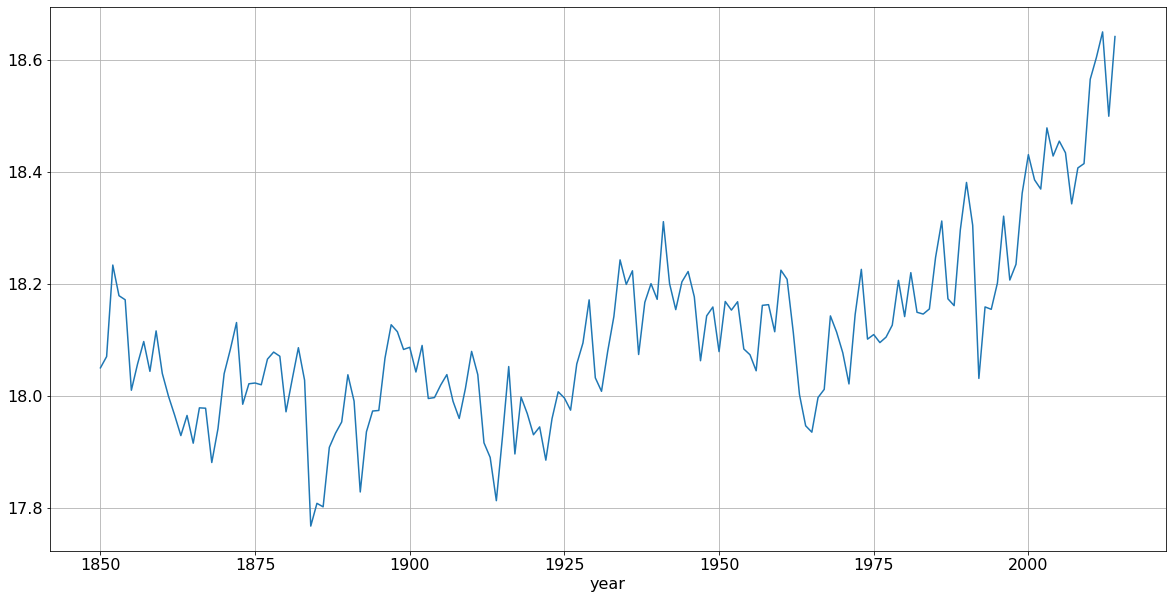

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
amean_tos.plot(ax=ax)
ax.grid(True)

In [35]:
(dset_ACCESS.tos.mean(dim='time') * dset_ACCESS.areacello).sum() / dset_ACCESS.areacello.sum()

<xarray.DataArray ()>
array(18.110752, dtype=float32)

In [5]:
def calc_CMIP_annual_means(var='tos', EXP='historical', vtype='Omon', ENS='r1i1p1f1'):

    amean_dset = xr.Dataset()
    model_list = []

    for ii, model in enumerate(allModels):

        files = Clist[model].getFiles(var=var, EXP=EXP, vtype=vtype, ENS=ENS)
        files_area = Clist[model].getFiles(var='areacello')

        if (len(files) != 0) & (len(files_area) != 0) & (model[:-4] != 'GFDL'):

            dset = xr.open_mfdataset(files, use_cftime=True)
            dset_area = xr.open_dataset(files_area[0])

            dset = xr.merge([dset, dset_area], compat='override')
            dset['areacello'].data[np.isnan(dset[var].isel(time=0).compute())] = 0

            amean_var = ((dset[var] * dset.areacello).sum(axis=(1,2)) / dset.areacello.sum()).groupby('time.year').mean() 

            amean_dset[(model + '_' + ENS)] = amean_var.compute()

            model_list.append((model + '_' + ENS))
            
    return amean_dset, model_list

### Now loop through all the models starting with the historical runs

In [8]:
amean_dset, model_list = calc_CMIP_annual_means(var='tos', EXP='historical', vtype='Omon', ENS='r1i1p1f1')

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol

In [9]:
amean_dset.to_netcdf('/home/users/train055/project04/data/processed_data/cmip6_historical_annual_mean_tos.nc')

Text(0.5, 1.0, 'tos historical Omon r1i1p1f1')

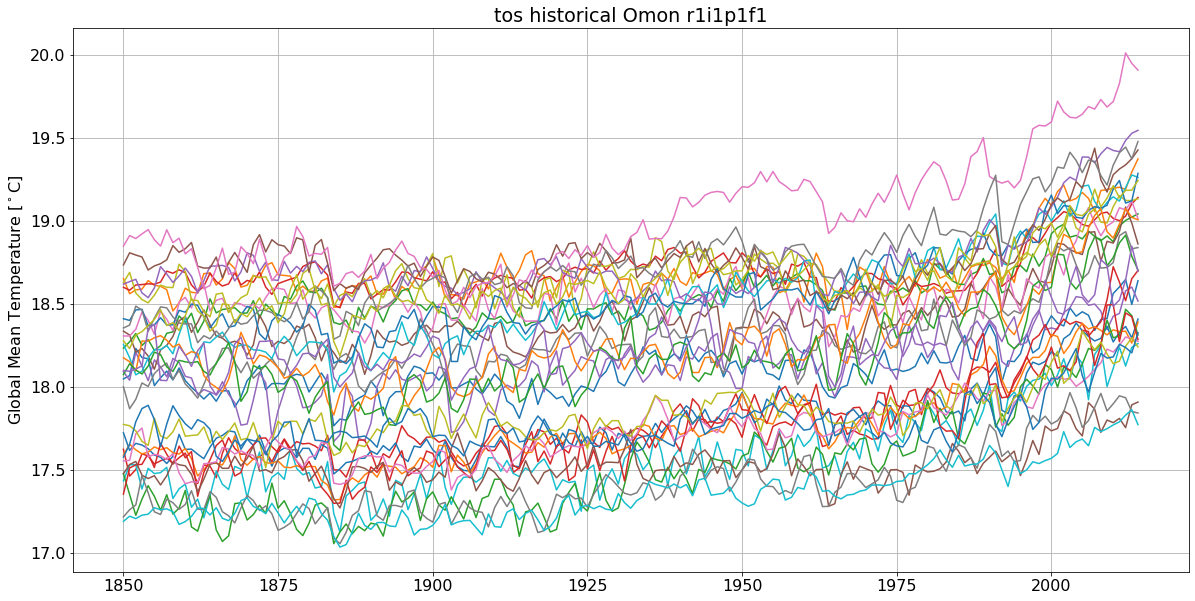

In [10]:
fig, ax = plt.subplots(figsize=(20,10))

for ii, model in enumerate(model_list):
    
    amean_dset[model].plot(ax=ax)

ax.grid(True)
ax.set_ylabel('Global Mean Temperature [$^\circ$C]')
ax.set_xlabel(None)
ax.set_title(('tos' + ' historical' + ' Omon' + ' r1i1p1f1'))

# plt.savefig('/gws/pw/j05/cop26_hackathons/bristol/project04/amoc_sst/cmip6_historical_annual_mean_tos.png', dpi=300, bbox_inches='tight')

## Now run for the scenarioMIP runs

### Start with ssp126

In [22]:
amean_dset, model_list = calc_CMIP_annual_means(var='tos', EXP='ssp126', vtype='Omon', ENS='r1i1p1f1')

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [29]:
amean_dset.to_netcdf('/home/users/train055/project04/data/processed_data/cmip6_ssp126_annual_mean_tos.nc')

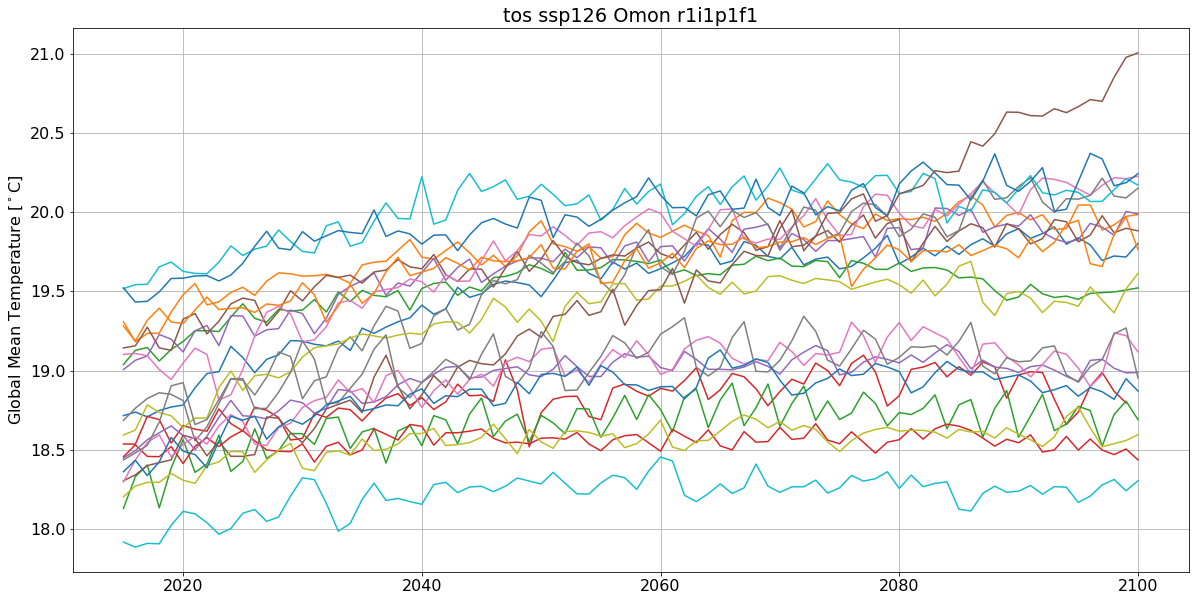

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

for ii, model in enumerate(model_list):
    
    amean_dset[(model + '_r1i1p1f1')].plot(ax=ax)

ax.grid(True)
ax.set_ylabel('Global Mean Temperature [$^\circ$C]')
ax.set_xlabel(None)
ax.set_title(('tos' + ' ssp126' + ' Omon' + ' r1i1p1f1'))

plt.savefig('/home/users/train055/project04/results/cmip6_ssp126_annual_mean_tos.png', dpi=300, bbox_inches='tight')

### Now do ssp245

In [30]:
amean_dset, model_list = calc_CMIP_annual_means(var='tos', EXP='ssp245', vtype='Omon', ENS='r1i1p1f1')

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [34]:
amean_dset.to_netcdf('/home/users/train055/project04/data/processed_data/cmip6_ssp245_annual_mean_tos.nc')

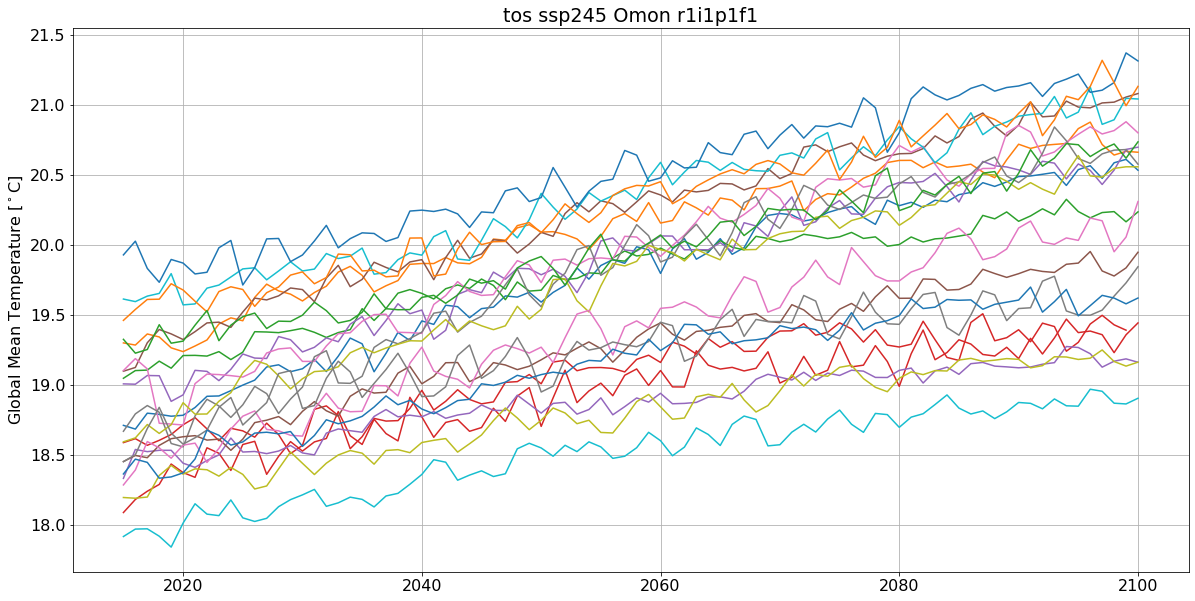

In [33]:
fig, ax = plt.subplots(figsize=(20,10))

for ii, model in enumerate(model_list):
    
    amean_dset[(model + '_r1i1p1f1')].plot(ax=ax)

ax.grid(True)
ax.set_ylabel('Global Mean Temperature [$^\circ$C]')
ax.set_xlabel(None)
ax.set_title(('tos' + ' ssp245' + ' Omon' + ' r1i1p1f1'))

plt.savefig('/home/users/train055/project04/results/cmip6_ssp245_annual_mean_tos.png', dpi=300, bbox_inches='tight')

### Now do ssp585

In [35]:
amean_dset, model_list = calc_CMIP_annual_means(var='tos', EXP='ssp585', vtype='Omon', ENS='r1i1p1f1')

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [37]:
amean_dset.to_netcdf('/home/users/train055/project04/data/processed_data/cmip6_ssp585_annual_mean_tos.nc')

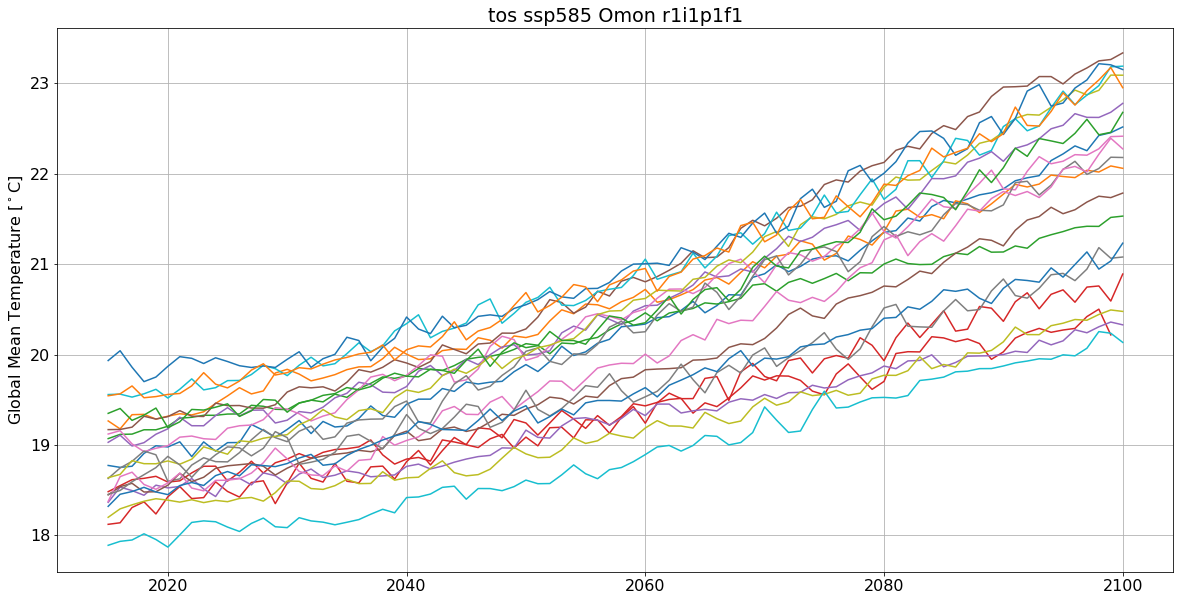

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

for ii, model in enumerate(model_list):
    
    amean_dset[(model)].plot(ax=ax)

ax.grid(True)
ax.set_ylabel('Global Mean Temperature [$^\circ$C]')
ax.set_xlabel(None)
ax.set_title(('tos' + ' ssp585' + ' Omon' + ' r1i1p1f1'))

plt.savefig('/home/users/train055/project04/results/cmip6_ssp585_annual_mean_tos.png', dpi=300, bbox_inches='tight')

In [38]:
amean_dset

<xarray.Dataset>
Dimensions:                    (year: 86)
Coordinates:
  * year                       (year) int64 2015 2016 2017 ... 2098 2099 2100
Data variables: (12/21)
    ACCESS-CM2_r1i1p1f1        (year) float32 18.77 18.75 18.77 ... 22.45 22.52
    ACCESS-ESM1-5_r1i1p1f1     (year) float32 19.27 19.18 19.34 ... 22.09 22.06
    BCC-CSM2-MR_r1i1p1f1       (year) float32 19.07 19.12 19.12 ... 21.52 21.53
    CAMS-CSM1-0_r1i1p1f1       (year) float32 18.48 18.55 18.62 ... 20.22 nan
    CESM2-WACCM_r1i1p1f1       (year) float32 19.03 19.11 18.99 ... 22.68 22.78
    CIESM_r1i1p1f1             (year) float32 19.17 19.17 19.2 ... 23.26 23.34
    ...                         ...
    FIO-ESM-2-0_r1i1p1f1       (year) float32 18.45 18.54 18.58 ... 21.74 21.79
    IPSL-CM6A-LR_r1i1p1f1      (year) float32 18.38 18.65 18.7 ... 22.39 22.28
    MIROC6_r1i1p1f1            (year) float32 18.45 18.5 18.59 ... 21.07 21.08
    MPI-ESM1-2-HR_r1i1p1f1     (year) float32 18.2 18.29 18.34 ... 20.49 20.48
    MPI-ESM1-2-LR_r1i1p1f1     (year) float32 17.89 17.93 17.95 ... 20.24 20.14
    MRI-ESM2-0_r1i1p1f1        (year) float32 18.32 18.46 18.49 ... 21.04 21.23